In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data_path = os.path.join(os.path.abspath(os.getcwd()), "..", "Database", "mushroom")

df_sub=pd.read_csv(os.path.join(data_path,"sample_submission.csv"))
df_train=pd.read_csv(os.path.join(data_path,"train.csv"))
df_test=pd.read_csv(os.path.join(data_path,"test.csv"))

In [3]:
df_train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


## Preprocessing

#### Remove id and missing values

In [4]:
missing_threshold = 0.95
high_missing_columns = df_train.columns[df_train.isnull().mean() > missing_threshold]

# Train
df_train = df_train.drop(columns=['id'])
df_train = df_train.drop(columns=high_missing_columns)

# Training
df_test = df_test.drop(columns=['id'])
df_test = df_test.drop(columns=high_missing_columns)

# Submission
df_sub = df_sub.drop(columns=['id'])
df_sub = df_sub.drop(columns=high_missing_columns)

#### Fill in missing data as mode or median

In [5]:
for column in df_train.columns:
    if df_train[column].isnull().any():      
        if df_train[column].dtype == 'object':
            _value = df_train[column].mode()[0]
        else:
            _value = df_train[column].median()
        
        df_train.fillna({column:_value}, inplace=True)
        df_test.fillna({column:_value}, inplace=True)

#### Fill in missing data with local mean (KNNImputer)

In [6]:
from sklearn.impute import KNNImputer

def knn_impute(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

df_train_imputed = knn_impute(df_train, n_neighbors=5)
df_test_imputed = knn_impute(df_test, n_neighbors=5)

#### Encode categorical data (str -> float)

In [7]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']

df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [8]:
df_train = df_train_imputed
df_test = df_test_imputed

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['class'] = le.fit_transform(df_train['class'])

### Assemble Data

In [10]:
X = df_train.drop(['class'], axis=1).to_numpy()
y = df_train["class"]
X

array([[ 8.8 , 53.  , 72.  , ..., 17.  , 25.  ,  0.  ],
       [ 4.51, 71.  , 56.  , ..., 17.  , 25.  ,  3.  ],
       [ 6.94, 53.  , 72.  , ..., 17.  , 36.  ,  3.  ],
       ...,
       [ 7.82, 71.  , 53.  , ..., 17.  , 25.  ,  0.  ],
       [ 9.45, 64.  , 59.  , ..., 17.  , 25.  ,  2.  ],
       [ 3.2 , 71.  , 72.  , ..., 17.  , 29.  ,  2.  ]])

## Classification

In [11]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.kernel_approximation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

models = [RandomForestClassifier()] #XGBoost , KNeighborsClassifier(), RandomForestClassifier(), SVC()]

for model in models:
    model.fit(X_train, y_train)


In [13]:
y_preds = [model.predict(X_test) for model in models]

## Meassure

In [14]:
from sklearn.metrics import matthews_corrcoef

mc_error = np.zeros(len(models))
for i in range(len(models)):
    mc_error[i] = matthews_corrcoef(y_test, y_preds[0])

#### Plot Matthews Correlation Coefficient for different models

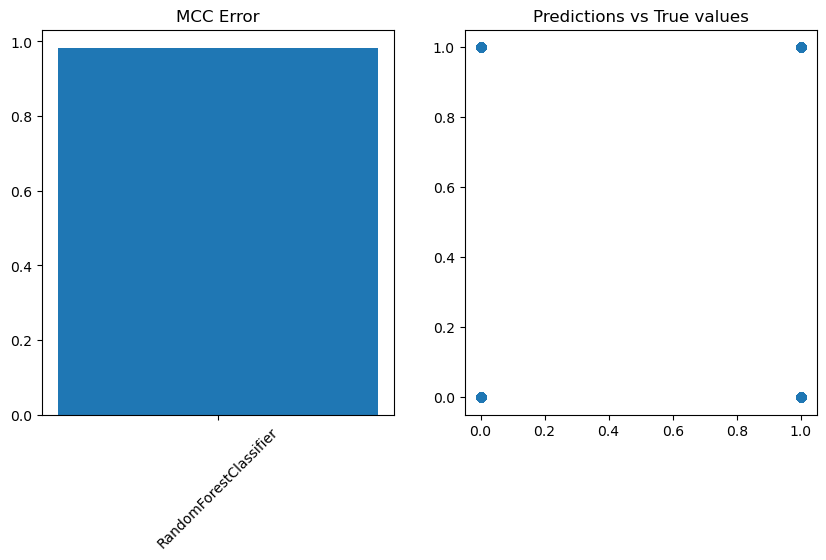

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(range(len(models)), mc_error)
axs[0].set_xticks(range(len(models)))
axs[0].set_xticklabels([model.__class__.__name__ for model in models], rotation=45)
axs[0].set_title('MCC Error')

axs[1].scatter(y_test, y_preds[0])
axs[1].set_title('Predictions vs True values')
plt.show()